# Artificial Intelligence Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this IPython notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [5]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


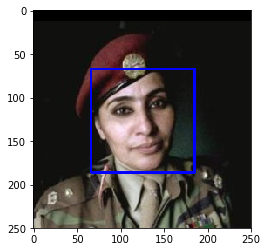

In [6]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [16]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

In [17]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
detector_human = [face_detector(img_path) for img_path in human_files_short]
detector_dog = [face_detector(img_path) for img_path in dog_files_short]
human_perc = sum(detector_human)/len(human_files_short)*100
dog_perc = sum(detector_dog)/len(dog_files_short)*100

f"{human_perc}% of human faces were correctly detected. {dog_perc}% of dog faces were detected as human faces."

'100.0% of human faces were correctly detected. 11.0% of dog faces were detected as human faces.'

__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__

We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on each of the datasets.

In [ ]:
## (Optional) TODO: Report the performance of another  
## face detection algorithm on the LFW dataset
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [18]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step: 


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [19]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [20]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [21]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

In [22]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_detector_human = [dog_detector(img_path) for img_path in human_files_short]
dog_detector_dog = [dog_detector(img_path) for img_path in dog_files_short]
human_perc = sum(dog_detector_human)/len(human_files_short)*100
dog_perc = sum(dog_detector_dog)/len(dog_files_short)*100

f"{dog_perc}% of dog images were correctly detected. {human_perc}% of human faces were detected as dogs."

'100.0% of dog images were correctly detected. 0.0% of human faces were detected as dogs.'

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [23]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 104.09it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ I sought inspiration from the winning architecture used in the CIFAR-10 competition on Kaggle that was [referenced during the lectures on CNNs](http://blog.kaggle.com/2015/01/02/cifar-10-competition-winners-interviews-with-dr-ben-graham-phil-culliton-zygmunt-zajac/). As I do not have the time and resources to train for 90 hours, I built an architecture that follows a similar general pattern (two convolutional layers followed by one 2x2 max pooling layer and increasing filter sizes with increasing depth of the network with dropout added after the first to convolutional layers), but represents an aggressively scaled down version of Ben Graham's set up. To finish off the network, I adapted the approach chosen in the sample architecture proposed above and flattened the network's dimensionality using global average pooling. To get the right number of classes I used a dense layer with 133 units.
Since I didn't know how long training would take, I chose to just use the first 6 convolutional layers instead of following Ben's architecture containing 12 conv layers closely. To start out slow I used a filter size of 16/16, 32/32 and 64/64 at first leading to a total of approx. 40k trainable parameters. Using this architecture, I was able to achieve 3.5% accuracy on the test set, which is already above the required 1%. To have a point of comparison, I implemented the basic architecture proposed above and evaluated it which got me approx. 2.3% test accuracy. To test how training time and accuracy respond to a larger network, I increased the number of filters in the convolutional layers to 1/10th of the numbers used by Ben Graham (32, 64, 96), which more than doubled the trainable paramameters to just over 100k and increased training time substantially. Luckily, the test accuracy improved as well to around 4.9% which I feel is a sizeable improvement compared to the baseline model provided in this notebook.

In [24]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.
model.add(Conv2D(filters=32, kernel_size=2, activation="relu", input_shape=(224,224,3)))
model.add(Conv2D(filters=32, kernel_size=2, activation="relu")) 
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, kernel_size=2, activation="relu"))
model.add(Dropout(0.1))
model.add(Conv2D(filters=64, kernel_size=2, activation="relu"))
model.add(Dropout(0.1))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(Conv2D(filters=96, kernel_size=2, activation="relu"))
model.add(Dropout(0.2))
model.add(Conv2D(filters=96, kernel_size=2, activation="relu"))
model.add(Dropout(0.2))
model.add(MaxPooling2D(pool_size=2, strides=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation="softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 32)      416       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 222, 222, 32)      4128      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 110, 110, 64)      8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 109, 109, 64)      0         
__________

I also implement the model architecture suggested above to have a point of comparison.

In [25]:
model_suggestion = Sequential()

model_suggestion.add(Conv2D(filters=16, kernel_size=2, activation="relu", input_shape=(224,224,3)))
model_suggestion.add(MaxPooling2D(pool_size=2, strides=2))
model_suggestion.add(Conv2D(filters=32, kernel_size=2, activation="relu"))
model_suggestion.add(MaxPooling2D(pool_size=2, strides=2))
model_suggestion.add(Conv2D(filters=64, kernel_size=2, activation="relu"))
model_suggestion.add(MaxPooling2D(pool_size=2, strides=2))
model_suggestion.add(GlobalAveragePooling2D())
model_suggestion.add(Dense(133, activation="softmax"))

model_suggestion.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_2 ( (None, 64)                0         
__________

### Compile the Model

##### My model

In [26]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

##### Suggested model

In [27]:
model_suggestion.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

##### My model

In [28]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 6

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/6
6680/6680 [==============================] - 75s 11ms/step - loss: 4.8860 - acc: 0.0090 - val_loss: 4.8718 - val_acc: 0.0108
Epoch 2/6
6680/6680 [==============================] - 73s 11ms/step - loss: 4.8553 - acc: 0.0159 - val_loss: 4.8420 - val_acc: 0.0204
Epoch 3/6
6680/6680 [==============================] - 73s 11ms/step - loss: 4.7914 - acc: 0.0166 - val_loss: 4.7811 - val_acc: 0.0275
Epoch 4/6
6680/6680 [==============================] - 73s 11ms/step - loss: 4.7277 - acc: 0.0253 - val_loss: 4.7085 - val_acc: 0.0263
Epoch 5/6
6680/6680 [==============================] - 73s 11ms/step - loss: 4.6506 - acc: 0.0371 - val_loss: 4.6708 - val_acc: 0.0347
Epoch 6/6
6680/6680 [==============================] - 73s 11ms/step - loss: 4.5808 - acc: 0.0391 - val_loss: 4.5588 - val_acc: 0.0407


##### Suggested model

In [29]:
epochs_suggestion = 6

checkpointer_suggestion = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_suggestion.hdf5', 
                               verbose=1, save_best_only=True)

model_suggestion.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs_suggestion, batch_size=20, callbacks=[checkpointer_suggestion], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/6
6680/6680 [==============================] - 20s 3ms/step - loss: 4.8824 - acc: 0.0102 - val_loss: 4.8669 - val_acc: 0.0168
Epoch 2/6
6680/6680 [==============================] - 20s 3ms/step - loss: 4.8552 - acc: 0.0135 - val_loss: 4.8352 - val_acc: 0.0156
Epoch 3/6
6680/6680 [==============================] - 20s 3ms/step - loss: 4.8118 - acc: 0.0171 - val_loss: 4.8104 - val_acc: 0.0192
Epoch 4/6
6680/6680 [==============================] - 20s 3ms/step - loss: 4.7757 - acc: 0.0202 - val_loss: 4.7785 - val_acc: 0.0168
Epoch 5/6
6680/6680 [==============================] - 20s 3ms/step - loss: 4.7432 - acc: 0.0216 - val_loss: 4.7596 - val_acc: 0.0240
Epoch 6/6
6680/6680 [==============================] - 20s 3ms/step - loss: 4.7156 - acc: 0.0241 - val_loss: 4.7619 - val_acc: 0.0263


### Load the Model with the Best Validation Loss

##### My model

In [30]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

##### Suggested model

In [31]:
model_suggestion.load_weights('saved_models/weights.best.from_scratch_suggestion.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

##### My model

In [32]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.9043%


##### Suggested model

In [33]:
dog_breed_predictions_suggestion = [np.argmax(model_suggestion.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy_suggestion = 100*np.sum(np.array(dog_breed_predictions_suggestion)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions_suggestion)
print('Test accuracy: %.4f%%' % test_accuracy_suggestion)

Test accuracy: 2.2727%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [34]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [36]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [37]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [38]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 290us/step - loss: 12.4525 - acc: 0.1153 - val_loss: 10.9908 - val_acc: 0.2000
Epoch 2/20
6680/6680 [==============================] - 2s 246us/step - loss: 10.5386 - acc: 0.2635 - val_loss: 10.4777 - val_acc: 0.2743
Epoch 3/20
6680/6680 [==============================] - 2s 246us/step - loss: 10.0717 - acc: 0.3195 - val_loss: 10.1885 - val_acc: 0.2958
Epoch 4/20
6680/6680 [==============================] - 2s 242us/step - loss: 9.8890 - acc: 0.3476 - val_loss: 10.1906 - val_acc: 0.3006
Epoch 5/20
6680/6680 [==============================] - 2s 245us/step - loss: 9.7671 - acc: 0.3654 - val_loss: 10.0228 - val_acc: 0.3186
Epoch 6/20
6680/6680 [==============================] - 2s 244us/step - loss: 9.7031 - acc: 0.3763 - val_loss: 10.0411 - val_acc: 0.3234
Epoch 7/20
6680/6680 [==============================] - 2s 244us/step - loss: 9.5356 - acc: 0.3882 - val_loss: 9.8775 - val_acc:

### Load the Model with the Best Validation Loss

In [39]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [40]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 40.9091%


### Predict Dog Breed with the Model

In [41]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  

The above architectures are downloaded and stored for you in the `/data/bottleneck_features/` folder.

This means the following will be in the `/data/bottleneck_features/` folder:

`DogVGG19Data.npz`
`DogResnet50Data.npz`
`DogInceptionV3Data.npz`
`DogXceptionData.npz`



### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('/data/bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [45]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features_ResNet50 = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features_ResNet50["train"]
valid_Resnet50 = bottleneck_features_ResNet50["valid"]
test_Resnet50 = bottleneck_features_ResNet50["test"]

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 



In [99]:
### TODO: Define your architecture.
Res50_model = Sequential()
Res50_model.add(Flatten(input_shape=train_Resnet50.shape[1:]))
Res50_model.add(Dense(133, activation='softmax'))

Res50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [47]:
### TODO: Compile the model.
Res50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [48]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Res50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 2s 275us/step - loss: 1.6127 - acc: 0.5976 - val_loss: 0.8182 - val_acc: 0.7473
Epoch 2/10
6680/6680 [==============================] - 1s 224us/step - loss: 0.4337 - acc: 0.8642 - val_loss: 0.6977 - val_acc: 0.7868
Epoch 3/10
6680/6680 [==============================] - 2s 228us/step - loss: 0.2643 - acc: 0.9130 - val_loss: 0.6400 - val_acc: 0.8024
Epoch 4/10
6680/6680 [==============================] - 2s 227us/step - loss: 0.1725 - acc: 0.9451 - val_loss: 0.7035 - val_acc: 0.7904
Epoch 5/10
6680/6680 [==============================] - 2s 226us/step - loss: 0.1213 - acc: 0.9633 - val_loss: 0.7292 - val_acc: 0.8000
Epoch 6/10
6680/6680 [==============================] - 2s 226us/step - loss: 0.0863 - acc: 0.9725 - val_loss: 0.6849 - val_acc: 0.8216
Epoch 7/10
6680/6680 [==============================] - 2s 226us/step - loss: 0.0627 - acc: 0.9817 - val_loss: 0.6927 - val_acc: 0.8168
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [49]:
### TODO: Load the model weights with the best validation loss.
Res50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [50]:
### TODO: Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Res50_predictions = [np.argmax(Res50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Res50_predictions)==np.argmax(test_targets, axis=1))/len(Res50_predictions)
print("Test accuracy: {:.4f}".format(test_accuracy))

Test accuracy: 79.7847


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [51]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

from extract_bottleneck_features import extract_Resnet50

def Res50_predict_breed(img_path):
    # extract bottleneck features
    _bottleneck_features = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Res50_model.predict(_bottleneck_features)
    # return dog breed
    return dog_names[np.argmax(predicted_vector)]

## EXTRA WORK - ROOM FOR IMPROVEMENT:
The model overfits pretty badly - 99% train accuracy vs. approx. 80% validation / test accuracy.

What can be done about this? Image augmentation is difficult as that would mean I could not use the bottleneck features and would have to just load the weights and push every image through the pretrained resnet architecture. I will try that anyway.
Approach:
- Use ResNet50 model loaded above with the imagenet weights, freeze these weights and add dense layer on top
- Use ImageDataGenerator to push augmented data through the network, just training the upper layer

#### But first, let's try just adding some dropout to the model trained above

In [102]:
### Define your architecture.
Res50_model_do = Sequential()
Res50_model_do.add(Flatten(input_shape=train_Resnet50.shape[1:]))
Res50_model_do.add(Dropout(0.35))
Res50_model_do.add(Dense(133, activation='softmax'))

### Compile the model.
Res50_model_do.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50_do.hdf5', 
                               verbose=1, save_best_only=True)

Res50_model_do.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)

### Load the model weights with the best validation loss.
Res50_model_do.load_weights('saved_models/weights.best.Resnet50_do.hdf5')

### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set
Res50_do_predictions = [np.argmax(Res50_model_do.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Res50_do_predictions)==np.argmax(test_targets, axis=1))/len(Res50_do_predictions)
print("Test accuracy: {:.4f}".format(test_accuracy))

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 17s 3ms/step - loss: 2.0223 - acc: 0.5105 - val_loss: 0.8411 - val_acc: 0.7533
Epoch 2/10
6680/6680 [==============================] - 3s 463us/step - loss: 0.6303 - acc: 0.8054 - val_loss: 0.6575 - val_acc: 0.7880
Epoch 3/10
6680/6680 [==============================] - 3s 473us/step - loss: 0.4476 - acc: 0.8569 - val_loss: 0.6786 - val_acc: 0.8024
Epoch 4/10
6680/6680 [==============================] - 3s 495us/step - loss: 0.3468 - acc: 0.8889 - val_loss: 0.6360 - val_acc: 0.8132
Epoch 5/10
6680/6680 [==============================] - 3s 477us/step - loss: 0.2936 - acc: 0.9064 - val_loss: 0.6542 - val_acc: 0.8108
Epoch 6/10
6680/6680 [==============================] - 3s 465us/step - loss: 0.2506 - acc: 0.9223 - val_loss: 0.6725 - val_acc: 0.8012
Epoch 7/10
6680/6680 [==============================] - 3s 460us/step - loss: 0.2231 - acc: 0.9308 - val_loss: 0.6656 - val_acc: 0.8240
Ep

This seems to help a bit, but doesn't really move the needle.

#### Let's try some data augmentation

##### Imports for using the model API

In [230]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.models import Model
from keras.layers import Flatten

##### Define the data generators

In [232]:
# settings
batch_size = 32
num_classes = 133
epochs = 6
steps_per_epoch = 200
validation_steps = 25
img_rows, img_cols = 224, 224
channels = 3

# data location
train_data_folder = "/data/dog_images/train"
valid_data_folder = "/data/dog_images/valid"
test_data_folder = "/data/dog_images/valid"

# generator settings
augmentation_params = {
        "rotation_range": 20, 
        "width_shift_range": 0.2, 
        "height_shift_range": 0.2,  
        "shear_range": 0.2,  
        "zoom_range": 0.2,  
        "fill_mode": 'nearest',  
        "horizontal_flip": True  
    }
        
generator_params_fit = {
          "batch_size": batch_size,
          "class_mode":"categorical",
          "color_mode":"rgb",
          "seed": 12345,
          "shuffle": True, 
          "target_size":(img_rows, img_cols)
    }
    
generator_params_eval = {
          "batch_size": batch_size,
          "class_mode":"categorical",
          "color_mode":"rgb",
          "seed": 12345,
          "shuffle": False, 
          "target_size":(img_rows, img_cols)
    }

In [233]:
generator_train = ImageDataGenerator(**augmentation_params).flow_from_directory(directory=train_data_folder, 
                                                                                **generator_params_fit)

generator_valid = ImageDataGenerator(**augmentation_params).flow_from_directory(directory=valid_data_folder, 
                                                                                **generator_params_eval)

generator_test = ImageDataGenerator(**augmentation_params).flow_from_directory(directory=test_data_folder, 
                                                                               **generator_params_eval)

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


##### Validate the results created by the generator

In [273]:
! mkdir generated_images

In [274]:
i = 0
for batch in ImageDataGenerator(**augmentation_params).flow_from_directory(directory=train_data_folder,
                                                                           batch_size=1,
                                                                           save_to_dir="generated_images",
                                                                           save_prefix="generated",
                                                                           save_format="jpeg"):
    i += 1
    if i > 20:
        break

Found 6680 images belonging to 133 classes.


##### Build the models

In [234]:
# Settings
weights = "imagenet" 
trainable_layers = 1

In [235]:
def build_model(model_function):
    
    base_model = model_function(include_top=False, 
                   weights="imagenet",
                   input_shape=(224,224,3))
    
    for layer in base_model.layers[:-trainable_layers]:
        layer.trainable = False

    x = Flatten()(base_model.output)
    output = Dense(133, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer="rmsprop",
              loss="categorical_crossentropy",
              metrics=['accuracy'])
    
    return model

model_VGG16_augmented = build_model(VGG16)
model_ResNet50_augmented = build_model(ResNet50)
model_inception_augmented = build_model(InceptionV3)
model_xception_augmented = build_model(Xception)

In [236]:
model_VGG16_augmented.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_58 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [237]:
model_ResNet50_augmented.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_59 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_59[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_2300 (Activation)    (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [238]:
model_inception_augmented.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 111, 111, 32) 864         input_60[0][0]                   
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, 111, 111, 32) 96          conv2d_108[0][0]                 
__________________________________________________________________________________________________
activation_2349 (Activation)    (None, 111, 111, 32) 0           batch_normalization_99[0][0]     
__________________________________________________________________________________________________
conv2d_109

In [239]:
model_xception_augmented.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_61 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_61[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

##### Fit the models

In [242]:
model_dict = {model_name : eval(model_name) for model_name in ["model_VGG16_augmented",
                                                  "model_ResNet50_augmented",
                                                  "model_inception_augmented", 
                                                  "model_xception_augmented"]}

In [243]:
def fit_model(model_name, model_object):
    checkpointer = ModelCheckpoint(filepath="saved_models/weights.best.{}.hdf5".format(model_name), 
                               verbose=1, save_best_only=True)

    model_object.fit_generator(
        generator=generator_train,
        steps_per_epoch=steps_per_epoch,
        validation_data=generator_valid,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks = [checkpointer]
    )

###### VGG16

In [244]:
# Fit VGG16
fit_model(model_name="VGG_augmented", model_object=model_dict["model_VGG16_augmented"])

Epoch 1/6
200/200 [==============================] - 169s 844ms/step - loss: 15.9289 - acc: 0.0111 - val_loss: 15.8562 - val_acc: 0.0163
Epoch 2/6
200/200 [==============================] - 137s 685ms/step - loss: 15.8302 - acc: 0.0174 - val_loss: 15.6620 - val_acc: 0.0275
Epoch 3/6
200/200 [==============================] - 141s 704ms/step - loss: 15.6793 - acc: 0.0256 - val_loss: 15.6125 - val_acc: 0.0300
Epoch 4/6
200/200 [==============================] - 140s 700ms/step - loss: 15.5023 - acc: 0.0355 - val_loss: 15.3846 - val_acc: 0.0437
Epoch 5/6
200/200 [==============================] - 139s 694ms/step - loss: 15.3931 - acc: 0.0440 - val_loss: 15.3188 - val_acc: 0.0475
Epoch 6/6
200/200 [==============================] - 139s 695ms/step - loss: 15.2702 - acc: 0.0517 - val_loss: 15.1953 - val_acc: 0.0563


###### ResNet50

In [245]:
# Fit ResNet50
fit_model(model_name="ResNet50_augmented", model_object=model_dict["model_ResNet50_augmented"])

Epoch 1/6
200/200 [==============================] - 234s 1s/step - loss: 3.0526 - acc: 0.2940 - val_loss: 1.9296 - val_acc: 0.4925
Epoch 2/6
200/200 [==============================] - 132s 662ms/step - loss: 1.4683 - acc: 0.6010 - val_loss: 1.5946 - val_acc: 0.5587
Epoch 3/6
200/200 [==============================] - 134s 669ms/step - loss: 1.1149 - acc: 0.6916 - val_loss: 1.4600 - val_acc: 0.5850
Epoch 4/6
200/200 [==============================] - 132s 660ms/step - loss: 0.9462 - acc: 0.7253 - val_loss: 1.4444 - val_acc: 0.6075
Epoch 5/6
200/200 [==============================] - 132s 661ms/step - loss: 0.8162 - acc: 0.7595 - val_loss: 1.4555 - val_acc: 0.6112
Epoch 6/6
200/200 [==============================] - 132s 659ms/step - loss: 0.7482 - acc: 0.7768 - val_loss: 1.5075 - val_acc: 0.6050


##### Inception

In [246]:
# Fit Inception
fit_model(model_name="Inception_augmented", model_object=model_dict["model_inception_augmented"])

Epoch 1/6
200/200 [==============================] - 303s 2s/step - loss: 14.3274 - acc: 0.0836 - val_loss: 13.5204 - val_acc: 0.1425
Epoch 2/6
200/200 [==============================] - 133s 666ms/step - loss: 13.5465 - acc: 0.1327 - val_loss: 13.2757 - val_acc: 0.1575
Epoch 3/6
200/200 [==============================] - 134s 671ms/step - loss: 13.2967 - acc: 0.1539 - val_loss: 13.2349 - val_acc: 0.1562
Epoch 4/6
200/200 [==============================] - 135s 673ms/step - loss: 13.0404 - acc: 0.1745 - val_loss: 13.1303 - val_acc: 0.1675
Epoch 5/6
200/200 [==============================] - 135s 673ms/step - loss: 13.0075 - acc: 0.1736 - val_loss: 12.7035 - val_acc: 0.1875
Epoch 6/6
200/200 [==============================] - 133s 667ms/step - loss: 12.7190 - acc: 0.1891 - val_loss: 12.6938 - val_acc: 0.1975


##### Xception

In [247]:
# Fit Xception
fit_model(model_name="Xception_augmented", model_object=model_dict["model_xception_augmented"])

Epoch 1/6
200/200 [==============================] - 215s 1s/step - loss: 8.2119 - acc: 0.3411 - val_loss: 6.2421 - val_acc: 0.5363
Epoch 2/6
200/200 [==============================] - 134s 670ms/step - loss: 5.4881 - acc: 0.5428 - val_loss: 5.6149 - val_acc: 0.5513
Epoch 3/6
200/200 [==============================] - 138s 690ms/step - loss: 5.0934 - acc: 0.5895 - val_loss: 5.6159 - val_acc: 0.5563
Epoch 4/6
200/200 [==============================] - 135s 677ms/step - loss: 4.7664 - acc: 0.6220 - val_loss: 5.1094 - val_acc: 0.6112
Epoch 5/6
200/200 [==============================] - 136s 680ms/step - loss: 4.4734 - acc: 0.6527 - val_loss: 4.9947 - val_acc: 0.6088
Epoch 6/6
200/200 [==============================] - 135s 677ms/step - loss: 4.3631 - acc: 0.6610 - val_loss: 5.3067 - val_acc: 0.6000


##### Evaluate the models

In [255]:
def evaluate_model(model_name, model_object):
    model_object.load_weights("saved_models/weights.best.{}.hdf5".format(model_name))
    predictions_test = [np.argmax(model_object.predict(np.expand_dims(image, axis=0))) for image in test_tensors]
    test_accuracy = 100*np.sum(np.array(predictions_test)==np.argmax(test_targets, axis=1))/len(predictions_test)
    return (model_object, predictions_test, test_accuracy)

##### VGG16

In [269]:
# Evaluate VGG16
best_model_VGG16, predictions_test_VGG16, test_acc_VGG16 = evaluate_model(model_name="VGG_augmented", 
                                                                          model_object=model_dict["model_VGG16_augmented"])


print("Test accuracy: {:4f}%".format(test_acc_VGG16))

Test accuracy: 1.315789%


##### ResNet50

In [282]:
# Evaluate ResNet50
best_model_ResNet50, predictions_test_ResNet50, test_acc_ResNet50 = evaluate_model(model_name="ResNet50_augmented", 
                                                                                  model_object=model_dict["model_ResNet50_augmented"])

print("Test accuracy: {:4f}%".format(test_acc_ResNet50))

Test accuracy: 0.956938%


##### Inception

In [252]:
# Evaluate Inception
evaluate_model(model_name="Inception_augmented", model_object=model_dict["model_inception_augmented"])

Test accuracy: 0.7177%


##### Xception

In [253]:
# Evaluate Xception
evaluate_model(model_name="Xception_augmented", model_object=model_dict["model_xception_augmented"])

Test accuracy: 0.7177%


##### The performance is awful. Why is that? It looks like now learning is taking place whatsoever...To have a fair point of comparison, I will try to recreate the results from above without using the extracted bottleneck features:

In [275]:
model_ResNet50_frozen = build_model(ResNet50)

In [276]:
model_ResNet50_frozen.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_62[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_2443 (Activation)    (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [278]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50_frozen.hdf5', 
                               verbose=1, save_best_only=True)

model_ResNet50_frozen.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=10, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 190s 28ms/step - loss: 2.4408 - acc: 0.4130 - val_loss: 7.4242 - val_acc: 0.0120
Epoch 2/10
6680/6680 [==============================] - 86s 13ms/step - loss: 0.8635 - acc: 0.7479 - val_loss: 6.1959 - val_acc: 0.0647
Epoch 3/10
6680/6680 [==============================] - 86s 13ms/step - loss: 0.5687 - acc: 0.8295 - val_loss: 1.7285 - val_acc: 0.5557
Epoch 4/10
6680/6680 [==============================] - 86s 13ms/step - loss: 0.4154 - acc: 0.8711 - val_loss: 1.1314 - val_acc: 0.6838
Epoch 5/10
6680/6680 [==============================] - 85s 13ms/step - loss: 0.3125 - acc: 0.9039 - val_loss: 1.2102 - val_acc: 0.6611
Epoch 6/10
6680/6680 [==============================] - 85s 13ms/step - loss: 0.2437 - acc: 0.9253 - val_loss: 1.2123 - val_acc: 0.6707
Epoch 7/10
6680/6680 [==============================] - 85s 13ms/step - loss: 0.2020 - acc: 0.9362 - val_loss: 1.2386 - val_acc: 0.6778


In [ ]:
best_model_ResNet50_frozen, predictions_test_ResNet50_frozen, test_acc_ResNet50_frozen = evaluate_model(model_name="ResNet50_frozen", 
                                                                                  model_object=model_ResNet50_frozen)

In [280]:
print("Test accuracy: {:4f}%".format(test_acc_ResNet50_frozen))

Test accuracy: 69.617225%


#### Okay, that's a sizeable difference, which leaves (at least) two open questions:
* What did I do differently when using ResNet50 as a mere feature extractor (model_ResNet50_frozen) compared to the bottleneck features provided by Udacity?
* What did I do wrong when using the data generators?

#### As I am already short on time and given that I achieved the required test accuracy >60%, I will leave it at that for the submission and hope to get some pointers from the reviewer ;-)

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [52]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

In [53]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [54]:
def face_detector_img(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [55]:
def say_hi(img, subject):
    print("Hi there! Looks like you're a {:s}!".format(subject))
    img_col = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_col)
    plt.show()

In [56]:
dog_names_clean = [name[7:].replace("_", " ") for name in dog_names]

def get_breed(img_path):
    # extract bottleneck features
    bottleneck_features = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Res50_model.predict(bottleneck_features)
    # return clean dog name
    return dog_names_clean[np.argmax(predicted_vector)]

In [86]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.
%matplotlib inline

def score_image(img_path):
    img = cv2.imread(img_path)
    if face_detector_img(img):
        say_hi(img, "human")
        print("But you do look a lot like a dog I must say. Give me a second to figure out which breed you remind me of...")
        print()
        dog_breed = get_breed(img_path)
        print("{:s}! It's {:s}! Don't you think?".format(dog_breed.upper(), dog_breed))
    elif dog_detector(img_path):
        say_hi(img, "dog")
        print("Give me a second to figure out which breed you might be...")
        print()
        dog_breed = get_breed(img_path)
        print("{:s}! You're a {:s}! Am I right?".format(dog_breed.upper(), dog_breed))
    else:
        print("Oops! I could not identify any humans or dogs in the picture you provided - sorry :-(")
        print("Please check for yourself - is there a human or a dog in this picture?")
        print("If I got thins wrong here, please make sure to provide images with an unobstructed view of the subject's face. I can only deal with those right now, sorry. Working hard to get better though!")
        img_col = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img_col)
        plt.show()

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ I am pretty happy with the performance of my algorithm. Identifying whether or not a dog is present in the image worked fine on all my test images with a clear view of the face. To me, this is the most important thing to get right to not risk user experience. To be fair, images of humans with an obstructed view of their face were not correctly identified. This was to be expected as I didn't pursue any optimization of the human detector.

When assessing the algorithm's performance in detecting the correct dog breed, I can only guess myself: All the dogs pictured are rescue dogs who lived in the streets and thus are most likely crossbreeds anyways. Encouragingly, many of the predictions are reasonably close to what I would suspect (e.g. images with indices 0 and 10) or ar at least comprehensible (indeces 1 and 9)

Room for improvement:
* Consistency in predictions: The images with the indices 0 and 9 display the same dog. As this is clearly visible to the human eye, the user would expect the app to predict the same breed for both images, which is not happening (the same is true for the human in images 5 and 6, myself). One approach to ensure this would be to add an additional human/dog recognition step, after the algorithms has identified which of the two we are dealing with.
* Latency: The predictions take a while. This is understandable given the size of the model used. While some of this might be covered by designing a good user experience, one possible point of improvement would be the speed of predictions, especially given the fact that the app would be expected to run on a mobile device. 
* Performance for images with an obstructed view of the face: Both images without a clear view of the subject's face were not correctly identified as a human. Therefore, the user must be clearly informed that a frontal image with an unobstructed view is required. Apparently, there are several promising approaches to achieving better performance on this ([this](https://github.com/davidsandberg/facenet) looks interesting for instance). However, I decided not to pursue them at the moment as I already spent a lot of time investigating image augmentation with pretrained networks (see above).

In [73]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# load image paths
my_image_paths = np.array(glob("my_images/*"))

Hi there! Looks like you're a dog!


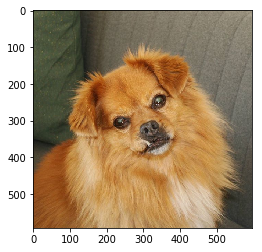

Give me a second to figure out which breed you might be...

POMERANIAN! You're a Pomeranian! Am I right?


In [87]:
score_image(my_image_paths[0])

Hi there! Looks like you're a dog!


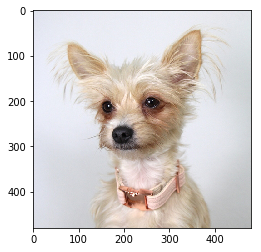

Give me a second to figure out which breed you might be...

CHINESE CRESTED! You're a Chinese crested! Am I right?


In [88]:
score_image(my_image_paths[1])

Hi there! Looks like you're a dog!


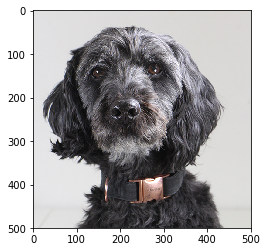

Give me a second to figure out which breed you might be...

HAVANESE! You're a Havanese! Am I right?


In [89]:
score_image(my_image_paths[2])

Oops! I could not identify any humans or dogs in the picture you provided - sorry :-(
Please check for yourself - is there a human or a dog in this picture?
If I got thins wrong here, please make sure to provide images with an unobstructed view of the subject's face. I can only deal with those right now, sorry. Working hard to get better though!


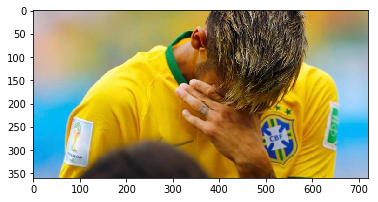

In [90]:
score_image(my_image_paths[3])

Oops! I could not identify any humans or dogs in the picture you provided - sorry :-(
Please check for yourself - is there a human or a dog in this picture?
If I got thins wrong here, please make sure to provide images with an unobstructed view of the subject's face. I can only deal with those right now, sorry. Working hard to get better though!


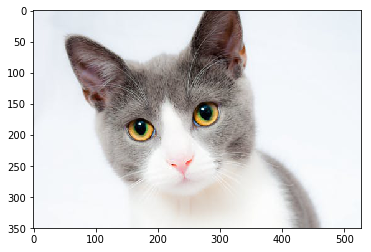

In [91]:
score_image(my_image_paths[4])

Hi there! Looks like you're a human!


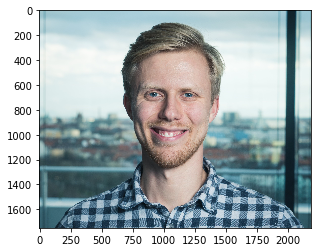

But you do look a lot like a dog I must say. Give me a second to figure out which breed you remind me of...

BULLMASTIFF! It's Bullmastiff! Don't you think?


In [92]:
score_image(my_image_paths[5])

Hi there! Looks like you're a human!


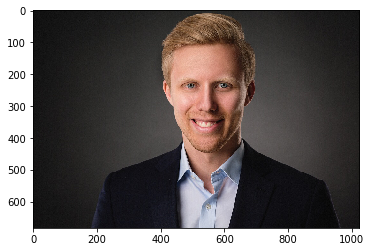

But you do look a lot like a dog I must say. Give me a second to figure out which breed you remind me of...

BEAGLE! It's Beagle! Don't you think?


In [93]:
score_image(my_image_paths[6])

Oops! I could not identify any humans or dogs in the picture you provided - sorry :-(
Please check for yourself - is there a human or a dog in this picture?
If I got thins wrong here, please make sure to provide images with an unobstructed view of the subject's face. I can only deal with those right now, sorry. Working hard to get better though!


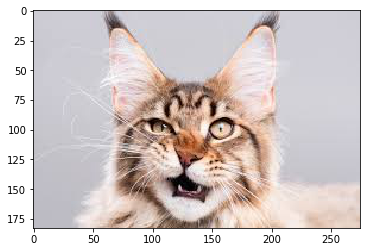

In [94]:
score_image(my_image_paths[7])

Hi there! Looks like you're a human!


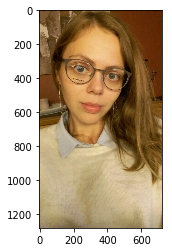

But you do look a lot like a dog I must say. Give me a second to figure out which breed you remind me of...

ENGLISH TOY SPANIEL! It's English toy spaniel! Don't you think?


In [95]:
score_image(my_image_paths[8])

Hi there! Looks like you're a dog!


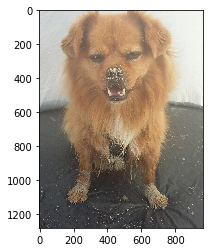

Give me a second to figure out which breed you might be...

NOVA SCOTIA DUCK TOLLING RETRIEVER! You're a Nova scotia duck tolling retriever! Am I right?


In [96]:
score_image(my_image_paths[9])

Hi there! Looks like you're a dog!


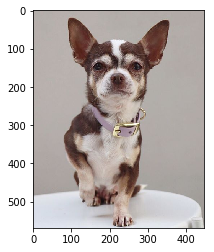

Give me a second to figure out which breed you might be...

CHIHUAHUA! You're a Chihuahua! Am I right?


In [97]:
score_image(my_image_paths[10])

Oops! I could not identify any humans or dogs in the picture you provided - sorry :-(
Please check for yourself - is there a human or a dog in this picture?
If I got thins wrong here, please make sure to provide images with an unobstructed view of the subject's face. I can only deal with those right now, sorry. Working hard to get better though!


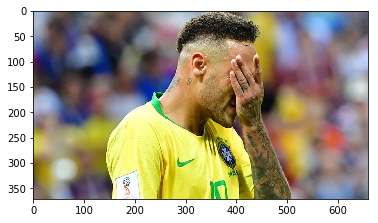

In [98]:
score_image(my_image_paths[11])

# Please download your notebook to submit